In [165]:
from scipy.io import arff
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import time

In [177]:
data1 = arff.loadarff(open('datasets/artificial/R15.arff','r'))
data2 = arff.loadarff(open('datasets/artificial/diamond9.arff','r'))
data3 = arff.loadarff(open('datasets/artificial/spherical_4_3.arff','r')) 

#Datasets for agglomerative clustering
data4 = arff.loadarff(open('datasets/artificial/zelnik3.arff','r'))
data5 = arff.loadarff(open('datasets/artificial/complex9.arff','r')) 
data6 = arff.loadarff(open('datasets/artificial/banana.arff','r'))

#Datasets for DBSCAN
data7 = arff.loadarff(open('datasets/artificial/zelnik2.arff','r'))
data8 = arff.loadarff(open('datasets/artificial/zelnik4.arff','r'))
data9 = arff.loadarff(open('datasets/artificial/cure-t2-4k.arff','r'))

#Comparison between HDB and DBSCAN
data10 = arff.loadarff(open('datasets/artificial/st900.arff','r'))
data11 = arff.loadarff(open('datasets/artificial/2sp2glob.arff','r'))
data12 = arff.loadarff(open('datasets/artificial/donut3.arff','r'))


AgglomerativeClustering(n_clusters=3)

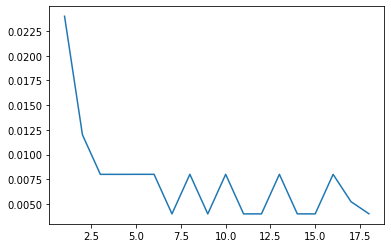

In [276]:
#Definition des fonctions

def init_df_cluster(df):
    return df[df.columns[0]], df[df.columns[1]]

def Kmeans(dataset, max_clusters = 20):
    
    df = pd.DataFrame(dataset[0])
    
    list_X, list_scores = [], []
    for i in range(2,max_clusters):
        kmeans = KMeans(n_clusters = i, random_state=0).fit(df)
        list_X.append(kmeans)
        list_scores.append(sklearn.metrics.silhouette_score(df, kmeans.labels_))
    max_value = max(list_scores)
    return list_X[list_scores.index(max_value)]

def Kmeans_inertia(dataset, max_clusters = 20, pourcentage = 0.05):
    list_X, list_scores = [], []
    
    for i in range(1,max_clusters):
        kmeans = KMeans(n_clusters = i, random_state=0).fit(df)
        list_X.append(kmeans)
        list_scores.append(kmeans.inertia_)

    best_cluster_number = len(Y2)

    for i in range(1, len(Y2)):
        ecart = Y2[i - 1] - Y2[i]  
        #print(f"i = {i}, Y2-1 = {Y2[i - 1]}, Y2 = {Y2[i]}")
        if (ecart < Y2[i - 1] * pourcentage):
            break
    return (list_X[i-1])
        
#print(Kmeans(data1))

def agglomerative(dataset, max_clusters = 20, show_time = False):
    
    time_list = []  
    df = pd.DataFrame(dataset[0])
    list_X, list_scores = [], []
    
    for i in range(2,max_clusters):
        timer = time.time()
        clusters = AgglomerativeClustering(n_clusters=i).fit(df)
        list_X.append(clusters)
        list_scores.append(sklearn.metrics.silhouette_score(df,clusters.labels_))
        max_value = max(list_scores)       
        time_list.append(time.time() - timer)
               
    if(show_time):
        plt.plot(np.linspace(1,max_clusters - 2,max_clusters - 2), time_list)
    return list_X[list_scores.index(max_value)]

#print(agglomerative(data4))
    
def plot_clusters_kmeans(dataset):
    df = pd.DataFrame(dataset[0])
    nom = Kmeans(dataset)
    X, Y = init_df_cluster(df)
    plt.scatter(X, Y, c = nom.labels_)
    plt.scatter(nom.cluster_centers_[:,0], nom.cluster_centers_[:,1], c='r', label = 'centers')
    plt.legend()
    
agglomerative(data4, show_time = True)


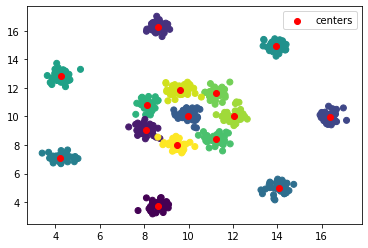

In [238]:
plot_clusters_kmeans(data1)

C:\Users\xSyl0\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


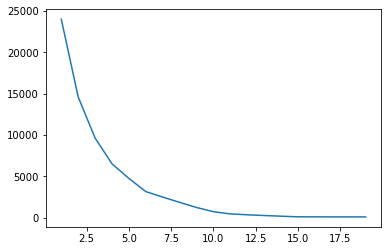

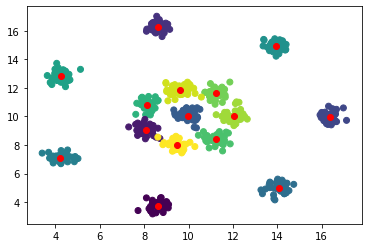

In [263]:
data = data1
df = pd.DataFrame(data[0])
X, Y = df['x'], df['y']
#print(df)

X2, Y2 = [], []
liste = []

j = 20

for i in range(1,j):
    kmeans = KMeans(n_clusters = i, random_state=0).fit(df)
    
    X2.append(i)
    Y2.append(kmeans.inertia_)
    liste.append(kmeans)
    
pourcentage = 0.05
best_cluster_number = len(Y2)

for i in range(1, len(Y2)):
    
    ecart = Y2[i - 1] - Y2[i]  
    #print(f"i = {i}, Y2-1 = {Y2[i - 1]}, Y2 = {Y2[i]}")
    if (ecart < Y2[i - 1] * pourcentage):
        #print(f"Le meilleur nombre de cluster est {i}")
        best_cluster_number = i
        break
        

plt.figure()
plt.plot(X2, Y2)

kmeans = KMeans(n_clusters = best_cluster_number, random_state=0).fit(df)
plt.figure()
plt.scatter(X, Y, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='r')

[0.36040329933166504, 0.03499960899353027, 0.026000022888183594, 0.04000067710876465, 0.05699968338012695, 0.07350897789001465, 0.059152841567993164, 0.05400681495666504, 0.04499983787536621, 0.06499242782592773, 0.08051204681396484, 0.0859994888305664, 0.08900141716003418, 0.09100103378295898, 0.10899996757507324, 0.10699772834777832, 0.11400127410888672, 0.11899828910827637, 0.1360020637512207]


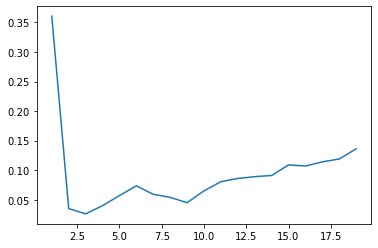

In [169]:
time_tab = []

time_start = time.time()
n = 20

for i in range(1,n):
    time_start = time.time()
    kmeans = KMeans(n_clusters = i, random_state=0).fit(df)
    X1.append(i)
    Y1.append(kmeans.inertia_)
    time_end = time.time()
    time_exec = time_end - time_start
    time_tab.append(time_exec)
    
print(time_tab)
    
    
X = np.linspace(1,n - 1,n - 1)
plt.figure()
plt.plot(X, time_tab)

Le nombre de cluster optimal est 3
0.9187192243245286


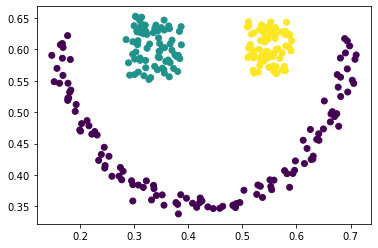

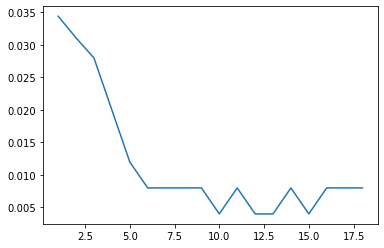

In [225]:
df = pd.DataFrame(data4[0])
X1, Y1 = [], []
X3, Y3 = df['x'], df['y']

list_clusters = []
time_tab = []

for i in range(2,n):
    time_start = time.time()
    clusters = AgglomerativeClustering(n_clusters=i).fit(df)
    list_clusters.append(clusters)
    score = sklearn.metrics.silhouette_score(df,clusters.labels_)
    X1.append(i)
    Y1.append(score)
    
    time_end = time.time()
    time_exec = time_end - time_start
    time_tab.append(time_exec)

best_score = max(Y1)
index_best_score = Y1.index(best_score)

print(f"Le nombre de cluster optimal est {index_best_score + 2}")
print(best_score)

plt.figure()
plt.scatter(X3, Y3, c = list_clusters[index_best_score].labels_)
plt.show()

X = np.linspace(1,n - 2,n - 2)
plt.figure()
plt.plot(X, time_tab)

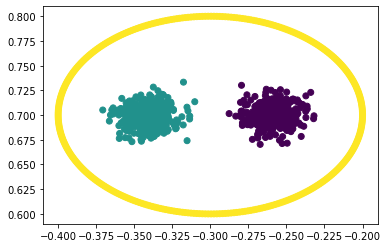

In [187]:
from sklearn.cluster import DBSCAN
X4, Y4 = df[df.columns[0]], df[df.columns[1]]

df = pd.DataFrame(data12[0])

df["class"] = df["class"].replace(b'noise', b'10')

DBSCAN_result = DBSCAN(eps = 1, min_samples = 10).fit(df)
plt.scatter(X4,Y4, c = DBSCAN_result.labels_)

In [174]:
X4, Y4 = df['x'], df['y']
for i in range(0, 5, 0.1):
    for j in range(21):
        #blabla y'aura des trucs ici
    

SyntaxError: unexpected EOF while parsing (<ipython-input-174-eddfe21a2c6c>, line 5)

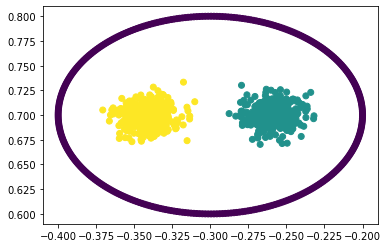

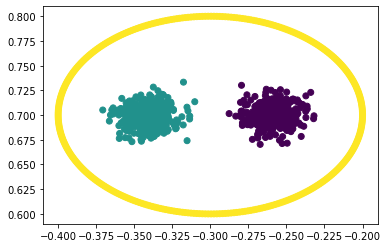

In [209]:
import hdbscan
df = pd.DataFrame(data12[0])
X5, Y5 = df[df.columns[0]], df[df.columns[1]]

df["class"] = df["class"].replace(b'noise', b'10')

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusterer_labels = clusterer.fit_predict(df)

plt.figure()
plt.scatter(X5, Y5, c = clusterer_labels)
plt.figure()
plt.scatter(X4, Y4, c = DBSCAN_result.labels_)

In [210]:
#Dataset du monde réel
data_real1 = arff.loadarff(open('datasets/real-world/iris.arff','r'))
data_real2 = arff.loadarff(open('datasets/real-world/balance-scale.arff','r'))